In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

import keras

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from keras.constraints import maxnorm

import keras
print (keras.__version__)

%matplotlib inline
sns.set(style="white")

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8] # width, height

Using TensorFlow backend.


2.1.4


In [2]:
# Configuration 

# Data sources
include_bitcoin = 1
include_ethereum = 1
include_litecoin = 1
include_ripple = 1
include_goog_trends = 1
include_stocktwits = 0

# Data duration (training + test)
start_date_ = '2015-08-07'
end_date_ = '2018-04-18'

start_date = start_date_.replace("-", "")
end_date = end_date_.replace("-", "")

# split_date = '2018-02-02'
split_date = '2018-01-20'  # >10% of full dataset

# Target : Predict bitcoin (OR ethereum) daily returns OR volatility 
# target = 'btc_daily_ret'
# target = 'btc_volatility'

target = 'eth_daily_ret'
# target = 'eth_volatility'

# Algorithm (LSTM - tune with GridSearch and sklearn's TimeSeriesSplit)
# window_size = 10
# how many days in advance

coins = ['bitcoin', 'ethereum', 'litecoin', 'ripple']
coin_symbol = {'bitcoin': 'btc', 'ethereum': 'eth', 'litecoin': 'ltc', 'ripple': 'xrp'}


In [3]:
# Load dataset
dataset_df = pd.read_pickle("data/full_dataset.pkl")

In [4]:
dataset_df.head()

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume,ltc_Close,ltc_Volume,xrp_Close,xrp_Volume,btc_close_off_high,...,ltc_30day_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,xrp_7day_ret,xrp_30day_ret,btc_trends,eth_trends,ltc_trends,xrp_trends
0,2015-08-07,279.58,42484800,2.770000,164329,4.21,4192810,0.008152,363643,0.597015,...,0.036946,0.987805,0.020449,0.016459,0.016459,0.016459,30.0,65.0,68.0,77.0
1,2015-08-08,261.00,58533000,0.753325,674188,3.85,4917730,0.008476,678295,-0.969823,...,-0.087678,0.147059,0.066634,0.038217,0.038217,0.038217,29.0,60.0,66.0,80.0
2,2015-08-09,265.08,23789600,0.701897,532170,3.90,3064680,0.008808,531969,0.411945,...,0.015625,0.914530,0.041372,0.038190,0.038190,0.038190,30.0,48.0,55.0,72.0
3,2015-08-10,264.47,20979400,0.708448,405283,3.95,2239890,0.008750,472973,-0.155756,...,0.012821,-0.949686,0.018044,-0.007036,-0.007036,-0.007036,30.0,46.0,51.0,85.0
4,2015-08-11,270.39,25433900,1.070000,1463100,4.16,3426300,0.008591,282461,1.000000,...,0.053165,-1.000000,0.019998,-0.018284,-0.018284,-0.018284,31.0,48.0,64.0,77.0


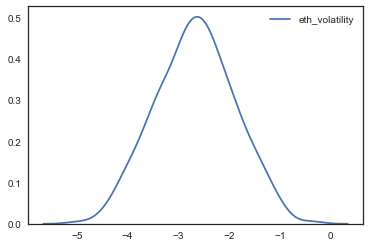

In [5]:
sns.kdeplot(np.log(dataset_df['eth_volatility']))

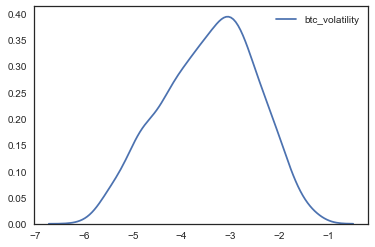

In [6]:
sns.kdeplot(np.log(dataset_df['btc_volatility']))

# Benchmarks

Benchmark -I: Price-Persistent model, assumes the close price is same as the previous day. Implies that the estimated daily returns and volatility are both zero

Benchmark - II: Market-Persistent model, assumes the daily returns is same as the previous day. Implies the estimated daily returns and volatility are same as the previous day.

In [7]:
## Price-PERSISTENT MODEL: Benchmark-I

print ("Predicting:", target)

# Evaluate on test dataset
# no change from previous day => pred_bitcoin = 0 (percent change) for persistence model
actual_target = dataset_df[dataset_df['Date']>= split_date][target].values
# pred_target = 0

bm1_mae = np.mean(np.absolute((actual_target)))
bm1_mse = np.mean(np.square((actual_target)))

print("Benchmark-I: MAE", bm1_mae)
print("Benchmark-I: MSE", bm1_mse)

Predicting: eth_daily_ret
Benchmark-I: MAE 0.04616467948128482
Benchmark-I: MSE 0.003542452975106516


In [8]:
## Market-PERSISTENT MODEL: Benchmark-II

# Evaluate on test dataset
# same market behavior as previous day
pred_target = dataset_df[dataset_df['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)][target][:-1].values

bm2_mae = np.mean(np.absolute((actual_target-pred_target)))
bm2_mse = np.mean(np.square((actual_target-pred_target)))

print("Benchmark-II: MAE", bm2_mae)
print("Benchmark-II: MSE", bm2_mse)

Benchmark-II: MAE 0.06758115531787437
Benchmark-II: MSE 0.007433466612293294


In [9]:
## LSTM Begins
symbols_ = [symbol+"_" for symbol in list(coin_symbol.values())]

# model_data = dataset_df[['Date']+[symbol+metric for symbol in symbols_ 
#                                    for metric in ['Close', 'Volume', 'close_off_high', 'volatility', 'daily_ret']]
#                         +[coin_symbol[coin]+"_trends" for coin in coins]]

model_data = dataset_df
model_data.head()

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume,ltc_Close,ltc_Volume,xrp_Close,xrp_Volume,btc_close_off_high,...,ltc_30day_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,xrp_7day_ret,xrp_30day_ret,btc_trends,eth_trends,ltc_trends,xrp_trends
0,2015-08-07,279.58,42484800,2.770000,164329,4.21,4192810,0.008152,363643,0.597015,...,0.036946,0.987805,0.020449,0.016459,0.016459,0.016459,30.0,65.0,68.0,77.0
1,2015-08-08,261.00,58533000,0.753325,674188,3.85,4917730,0.008476,678295,-0.969823,...,-0.087678,0.147059,0.066634,0.038217,0.038217,0.038217,29.0,60.0,66.0,80.0
2,2015-08-09,265.08,23789600,0.701897,532170,3.90,3064680,0.008808,531969,0.411945,...,0.015625,0.914530,0.041372,0.038190,0.038190,0.038190,30.0,48.0,55.0,72.0
3,2015-08-10,264.47,20979400,0.708448,405283,3.95,2239890,0.008750,472973,-0.155756,...,0.012821,-0.949686,0.018044,-0.007036,-0.007036,-0.007036,30.0,46.0,51.0,85.0
4,2015-08-11,270.39,25433900,1.070000,1463100,4.16,3426300,0.008591,282461,1.000000,...,0.053165,-1.000000,0.019998,-0.018284,-0.018284,-0.018284,31.0,48.0,64.0,77.0


In [10]:

training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]

# we don't need the date columns anymore
########### DONT'WE ?? - If we are to cross-validation, we need the dates!! or we just use the index?
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [11]:
# LSTM Parameters

window_len = 7 # 25 # 20 10
neurons = 100
batch_size = 1
epochs = 20
no_of_features = training_set.shape[1]

# Columns to be normalized - Instead of traditional normalization aschemes (like MinMax on training_set), 
# normalize the columns w.r.t to the first element of the window s.t the normalized first element would be 0 
# Reference: 
norm_cols = [[symbol+metric for symbol in symbols_ for metric in ['Close','Volume']]          
             +[coin_symbol[coin]+"_trends" for coin in coins]]

norm_cols

[['btc_Close',
  'btc_Volume',
  'eth_Close',
  'eth_Volume',
  'ltc_Close',
  'ltc_Volume',
  'xrp_Close',
  'xrp_Volume',
  'btc_trends',
  'eth_trends',
  'ltc_trends',
  'xrp_trends']]

In [12]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = training_set[target][window_len:].values

In [13]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)

LSTM_test_outputs = test_set[target][window_len:].values

print(len(training_set))
print(len(test_set))

897
89


In [14]:
# ???  easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

type(LSTM_test_inputs)

numpy.ndarray

In [ ]:
# Function to create model, required for KerasRegressor
def create_model(dropout, neurons):
    # use default values
    init_mode='uniform'
    weight_constraint=0 # or  4
    lr = 0.01
    momemntum=0

    loss= 'mse'
    optimizer='adam'
    activ_func='linear'
    output_size = 1 # TODO: Can we change this to 2 or even 4 (to predict all 4 at a time - {eth, btc}_{volatility, daily_ret})
    
    print ("Start model: ", dropout, neurons)
    
    model = Sequential()

    model.add(LSTM(neurons[0], return_sequences=True, input_shape=(window_len, no_of_features)))
    # model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    
    model.add(LSTM(neurons[1], return_sequences=True))
    model.add(Dropout(dropout))
    
    model.add(LSTM(neurons[2]))
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    print ("End compilation of model: ", dropout, neurons)
    
    return model

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# create model
model = KerasRegressor(build_fn=create_model, batch_size=4, epochs=10) 
##############################################################
# grid search: dropout, neurons
dropout = [0.5, 0.75]  # [0.25, 0.5]
neurons = [[10, 8, 4], [20, 16, 8], [40, 32, 16]]
param_space = dict(dropout=dropout, neurons=neurons)
##############################################################
tseries_cv = TimeSeriesSplit(n_splits=5).split(LSTM_training_inputs)

grid = GridSearchCV(estimator=model, param_grid=param_space, n_jobs=1, cv=tseries_cv, verbose=5)

print ("Train input shape: ", LSTM_training_inputs.shape)
print ("Train output shape: ", LSTM_training_outputs.shape)

grid_result = grid.fit(LSTM_training_inputs, LSTM_training_outputs)
##############################################################
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Train input shape:  (890, 7, 32)
Train output shape:  (890,)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] dropout=0.5, neurons=[10, 8, 4] .................................
Start model:  0.5 [10, 8, 4]
End compilation of model:  0.5 [10, 8, 4]
Epoch 1/10
150/150 [==============================] - 3s 20ms/step - loss: 0.0115
Epoch 2/10
150/150 [==============================] - 0s 3ms/step - loss: 0.0080
Epoch 3/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 4/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 5/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 6/10
150/150 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 7/10
150/150 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 8/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 9/10
150/150 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s remaining:    0.0s


End compilation of model:  0.5 [10, 8, 4]
Epoch 1/10
298/298 [==============================] - 4s 12ms/step - loss: 0.0164
Epoch 2/10
298/298 [==============================] - 1s 2ms/step - loss: 0.0112
Epoch 3/10
298/298 [==============================] - 1s 2ms/step - loss: 0.0088
Epoch 4/10
298/298 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 5/10
298/298 [==============================] - 1s 2ms/step - loss: 0.0082
Epoch 6/10
298/298 [==============================] - 1s 2ms/step - loss: 0.0076
Epoch 7/10
298/298 [==============================] - 1s 2ms/step - loss: 0.0078
Epoch 8/10
298/298 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 9/10
298/298 [==============================] - 1s 3ms/step - loss: 0.0072
Epoch 10/10
298/298 [==============================] - 0s 565us/step
[CV]  dropout=0.5, neurons=[10, 8, 4], score=-0.003381627316058085, total=  15.6s
[CV] dropout=0.5, neurons=[10, 8, 4] .................................
Start 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.9s remaining:    0.0s


End compilation of model:  0.5 [10, 8, 4]
Epoch 1/10
446/446 [==============================] - 4s 9ms/step - loss: 0.0062
Epoch 2/10
446/446 [==============================] - 1s 3ms/step - loss: 0.0060
Epoch 3/10
446/446 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 4/10
446/446 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 5/10
446/446 [==============================] - 2s 4ms/step - loss: 0.0058
Epoch 6/10
446/446 [==============================] - 2s 4ms/step - loss: 0.0057
Epoch 7/10
446/446 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 8/10
446/446 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 9/10
446/446 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 10/10
446/446 [==============================] - 0s 598us/step
[CV]  dropout=0.5, neurons=[10, 8, 4], score=-0.004614245095974577, total=  20.1s
[CV] dropout=0.5, neurons=[10, 8, 4] .................................
Start m

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.3s remaining:    0.0s


End compilation of model:  0.5 [10, 8, 4]
Epoch 1/10
594/594 [==============================] - 5s 9ms/step - loss: 0.0077
Epoch 2/10
594/594 [==============================] - 2s 3ms/step - loss: 0.0060
Epoch 3/10
594/594 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 4/10
594/594 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 5/10
594/594 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 6/10
594/594 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 7/10
594/594 [==============================] - 1s 2ms/step - loss: 0.0053
Epoch 8/10
594/594 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 9/10
594/594 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 10/10
594/594 [==============================] - 0s 552us/step
[CV]  dropout=0.5, neurons=[10, 8, 4], score=-0.005934676158987615, total=  24.4s
[CV] dropout=0.5, neurons=[10, 8, 4] .................................
Start m

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


End compilation of model:  0.5 [10, 8, 4]
Epoch 1/10
742/742 [==============================] - 5s 7ms/step - loss: 0.0076
Epoch 2/10
742/742 [==============================] - 2s 3ms/step - loss: 0.0059
Epoch 3/10
742/742 [==============================] - 2s 2ms/step - loss: 0.0056
Epoch 4/10
742/742 [==============================] - 2s 3ms/step - loss: 0.0056
Epoch 5/10
742/742 [==============================] - 2s 3ms/step - loss: 0.0056
Epoch 6/10
742/742 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 7/10
742/742 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 8/10
742/742 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 9/10
742/742 [==============================] - 2s 2ms/step - loss: 0.0055
Epoch 10/10
742/742 [==============================] - 0s 576us/step
[CV]  dropout=0.5, neurons=[10, 8, 4], score=-0.003853537448260279, total=  27.2s
[CV] dropout=0.5, neurons=[20, 16, 8] ................................
Start m

Epoch 2/10
298/298 [==============================] - 1s 3ms/step - loss: 0.0085
Epoch 3/10
298/298 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 4/10
298/298 [==============================] - 1s 3ms/step - loss: 0.0073
Epoch 5/10
298/298 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 6/10
298/298 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 7/10
298/298 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 8/10
298/298 [==============================] - 1s 3ms/step - loss: 0.0072
Epoch 9/10
298/298 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 10/10
298/298 [==============================] - 0s 656us/step
[CV]  dropout=0.5, neurons=[40, 32, 16], score=-0.003826251479237013, total=  21.3s
[CV] dropout=0.5, neurons=[40, 32, 16] ...............................
Start model:  0.5 [40, 32, 16]
End compilation of model:  0.5 [40, 32, 16]


In [ ]:
# fig, ax1 = plt.subplots(1,1)

# ax1.plot(bt_history.epoch, bt_history.history['loss'])
# ax1.set_title('Training Error')

# if bt_model.loss == 'mae':
#     ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# elif bt_model.loss == 'mse':
#     ax1.set_ylabel('Mean Squared Error (MSE)',fontsize=12)
# else:
#     ax1.set_ylabel('Model Loss',fontsize=12)
# ax1.set_xlabel('# Epochs',fontsize=12)
# plt.show()

In [ ]:
bt_model = grid_result.best_estimator_
grid_result.best_params_

In [ ]:
fig, ax1 = plt.subplots(1,1)
LSTM_test_outputs = training_set[target][window_len:].values
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         (bt_model.predict(LSTM_test_inputs)), 
         label='Predicted')
lstm_mse=np.mean(np.square(bt_model.predict(LSTM_test_inputs)-(test_set[target].values[window_len:])))
ax1.annotate('MSE: %.4f'%lstm_mse, xy=(0.75, 0.9),  xycoords='axes fraction', xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price change (%)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         (bt_model.predict(LSTM_training_inputs)), 
         label='Predicted')
ax1.annotate('MSE: %.4f'%np.mean(np.square(bt_model.predict(LSTM_training_inputs)-\
            (training_set[target].values[window_len:]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Training Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [ ]:
pred_values = bt_model.predict(LSTM_training_inputs)
max(pred_values)
min(pred_values)

In [ ]:
print (bm1_mse)
print (bm2_mse)
print (lstm_mse)

In [ ]:
# Use loss as MSE to strongly penalize large errors
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.5, loss="mse", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    # model.add(LSTM(25, return_sequences=True))
    # model.add(Dropout(dropout))
    model.add(LSTM(2*neurons))
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model